In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

In [2]:
parse = tasks.load_parse(data_dir)
parse.head(25)

,subject,run,block,trial,trial_type,path_type,community,transition,prev_walk,object,object_type,response,response_time
0,100,1,1,1,random,random,1,False,0,21,central,0,NaN
1,100,1,1,2,random,random,1,False,0,3,boundary,0,NaN
2,100,1,1,3,random,random,1,False,0,20,central,1,0.818487
3,100,1,1,4,random,random,1,False,0,3,boundary,0,NaN
4,100,1,1,5,random,random,1,False,0,2,central,1,0.914617
5,100,1,1,6,random,random,1,False,0,3,boundary,1,0.769570
6,100,1,1,7,random,random,2,True,6,4,boundary,0,NaN
7,100,1,1,8,random,random,2,False,6,8,central,1,0.949561
8,100,1,1,9,random,random,2,False,6,10,boundary,0,NaN
9,100,1,1,10,random,random,2,False,6,8,central,0,NaN


In [3]:
trans_parse = (
    parse.query('transition and prev_walk >= 4')
    .groupby(['subject', 'trial_type'])['response']
    .mean()
)
other_parse = (
    parse.query('~(transition and prev_walk >= 4)')
    .groupby(['subject', 'trial_type'])['response']
    .mean()
)
results = pd.concat([trans_parse, other_parse], keys=['transition', 'other'])
results.index.set_names('parse_type', level=0, inplace=True)
results = results.reset_index()
parse_type = results['parse_type'].astype('category')
parse_type = parse_type.cat.set_categories(['transition', 'other'])
results['parse_type'] = parse_type

In [4]:
# light = [(.9, .9, .9), (.6, .6, .6)]
# dark = [(.7, .7, .7), (.4, .4, .4)]
light = [
    (240 / 256, 96 / 256, 130 / 256),
    (238 / 256, 191 / 256, 202 / 256),
]
dark = [
    (237 / 256, 38 / 256, 81 / 256),
    (238 / 256, 155 / 256, 175 / 256),
]
sns.color_palette(light + dark)

[(0.9375, 0.375, 0.5078125),
 (0.9296875, 0.74609375, 0.7890625),
 (0.92578125, 0.1484375, 0.31640625),
 (0.9296875, 0.60546875, 0.68359375)]

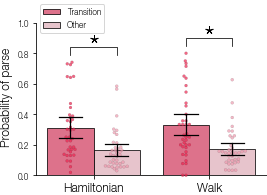

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    results.reset_index(),
    x='trial_type',
    y='response',
    hue='parse_type',
    dodge=True,
    light=light,
    dark=dark,
    bar_kws={'capsize': .2},
    ax=ax,
)

# plot significance bars
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = results.groupby(['trial_type', 'parse_type'])['response'].max().to_list()
statplot.plot_sig([x[0], x[1]], [y[0], y[1]], 0.05, ax=ax)
statplot.plot_sig([x[2], x[3]], [y[2], y[3]], 0.05, ax=ax)

ax.set(xticklabels=['Hamiltonian', 'Walk'], ylabel='Probability of parse', ylim=[0, 1.15])
handles, labels = ax.get_legend_handles_labels()
ax.spines['left'].set_bounds(0, 1)
ax.legend(handles, ['Transition', 'Other'], fontsize='small', loc='upper left');
ax.yaxis.set_label_coords(-.1, 0.45)
fig.savefig(os.path.join(fig_dir, 'parsing_transition.pdf'))

In [6]:
pg.rm_anova(
    data=results, 
    dv='response', 
    within=['parse_type', 'trial_type'], 
    subject='subject',
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,parse_type,0.849669,1,36,0.849669,15.051585,0.000428,0.000428,0.294831,1.0
1,trial_type,0.006734,1,36,0.006734,1.482096,0.231367,0.231367,0.039541,1.0
2,parse_type * trial_type,0.000497,1,36,0.000497,0.171376,0.681348,0.681348,0.004738,1.0


In [7]:
pivot = pd.pivot(
    results, 
    index='subject', 
    values='response', 
    columns=['trial_type', 'parse_type'],
)

In [8]:
pg.ttest(pivot[('hamiltonian', 'transition')], pivot[('hamiltonian', 'other')], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.042153,36,two-sided,0.000267,"[0.07, 0.22]",0.872559,102.045,0.999317


In [9]:
pg.ttest(pivot[('random', 'transition')], pivot[('random', 'other')], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.589192,36,two-sided,0.00098,"[0.07, 0.24]",0.873636,31.801,0.999332


In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

seaborn   : 0.11.1
pandas    : 1.2.4
numpy     : 1.18.1
mindstorm : 0.8.0
tesser    : 0.1.0
matplotlib: 3.1.3
pingouin  : 0.3.11

